In [1]:
## Alway run this block first! 
%matplotlib inline
# coding=utf-8

import sys
import datetime
sys.path.extend(['/Users/Dim/Desktop/school_folder/masters_thesis/gitCodeRepo/codePython/collateralOptimizer/'])
import time
from dataPreProcess import *
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Set the path and filename of the historical data to be used
filePath = "/Users/Dim/Desktop/school_folder/masters_thesis/gitCodeRepo/data/"
fileName = "historicalData_fill_20160809.csv"

# Read .csv file, prepare an appropriate subset of the data, calculate variance-covariance matrix
dictData = prepareData(filePath, fileName)
tsData   = fetchDataSubset(dictData['data'], dictData['tfdata'], dictData['date'], lookbackLength = 0)['data']
tsDate   = fetchDataSubset(dictData['data'], dictData['tfdata'], dictData['date'], lookbackLength = 0)['date']
Sigma    = prepareSigma(tsData)

# Align df's to common date based index
tsData = pd.concat([tsData, tsDate], axis=1)
tsData = tsData.set_index('date')

# Adjust "MXHK Index ISIN" index is in HKD, equity is in USD
hkIndex_HKD = pd.to_numeric(tsData['MXHK Index ISIN'])
crcyHKDUSD  = pd.to_numeric(tsData['HKDUSD BGN Curncy ISIN'])

# Apply CCY conversion
hkIndex_USD = np.multiply(hkIndex_HKD, crcyHKDUSD)
hkIndex_USD = hkIndex_USD.rename("MXHK (USD) Index ISIN")
tsData      = pd.concat([tsData, hkIndex_USD], axis=1)

# Calculate relative returns R_t = (X_t / X_t-1) - 1 ->> For now use pandas built-in function
# tsDataReturns = tsData.pct_change(1) verified to produce consistent results with above
# returns = (vfiax_monthly.open - vfiax_monthly.open.shift(1))/vfiax_monthly.open
tsReturns = tsData.apply(pd.to_numeric)
tsReturns = tsReturns.pct_change()
tsReturns = tsReturns.dropna(axis=0)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2809: DtypeWarning: Columns (1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58,61,64,67,70,73,76,79,82,85,88,91,94,97,100,103,106,109,112,115,118,121,124,127,130,133,136,139,142,145,148,151,154,157,160,163,166,169,172,175,178,181,184,187,190,193,196,199,202,205,208,211,214,217,220,223,226,229,232,235,238,241,244,247,250,253,256,259,262,265) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### General correlation structure of the data in question

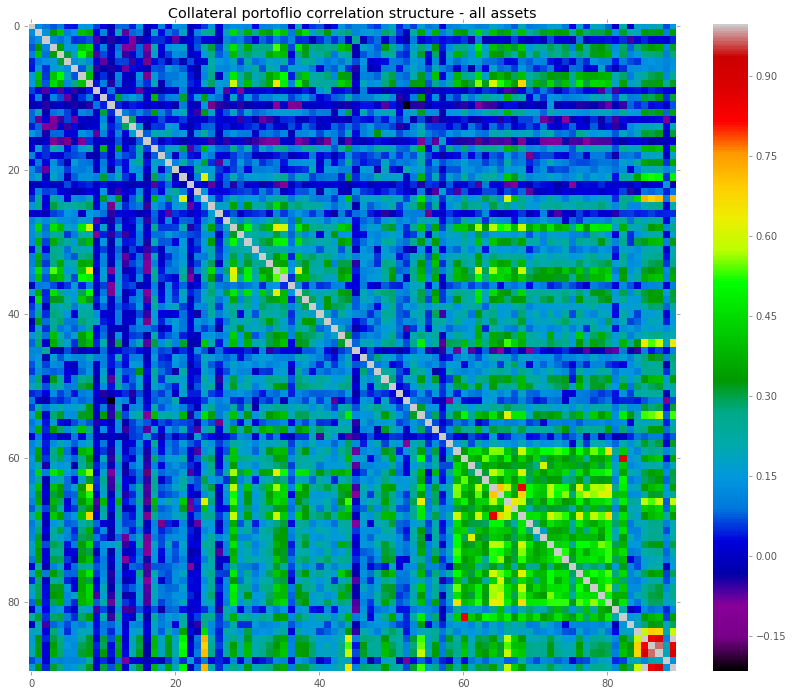

In [33]:
def plot_matrix(mat, figsize, title='example', cmap=plt.cm.spectral):
    f = plt.figure(figsize=figsize)
    ax = plt.axes([0, 0.05, 0.9, 0.9 ]) #left, bottom, width, height
    #note that we are forcing width:height=1:1 here, 
    #as 0.9*8 : 0.9*8 = 1:1, the figure size is (8,8)
    #if the figure size changes, the width:height ratio here also need to be changed
    im = ax.imshow(mat, interpolation='nearest', cmap=cmap)
    ax.grid(False)
    ax.set_title(title)
    cax = plt.axes([0.95, 0.05, 0.05,0.9 ])
    plt.colorbar(mappable=im, cax=cax)
    return ax, cax

data = tsReturns.corr()
ax, cax = plot_matrix(data, (10,10), title='Collateral portoflio correlation structure - all assets')
plt.savefig("matrixPlot" 
            + "_fullCorrelationStruct_"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

# Approach 0 - Descriptive statistics and direct mapping of index returns to target series
## The idea here is to exploit the possibility of using a direct mapping, based on the industry and risk domicile (as provided by Bloomberg) to model the missing returns

                          MXHK (USD) Index ISIN  MXAS0IN Index ISIN  \
MXHK (USD) Index ISIN                  1.000000            0.592014   
MXAS0IN Index ISIN                     0.592014            1.000000   
MMDUAAJ Index ISIN                     0.839996            0.689794   
MXASJ Index ISIN                       0.887444            0.676844   
KYG217651051 Equity ISIN               0.310613            0.134355   

                          MMDUAAJ Index ISIN  MXASJ Index ISIN  \
MXHK (USD) Index ISIN               0.839996          0.887444   
MXAS0IN Index ISIN                  0.689794          0.676844   
MMDUAAJ Index ISIN                  1.000000          0.971017   
MXASJ Index ISIN                    0.971017          1.000000   
KYG217651051 Equity ISIN            0.274498          0.293491   

                          KYG217651051 Equity ISIN  
MXHK (USD) Index ISIN                     0.310613  
MXAS0IN Index ISIN                        0.134355  
MMDUAAJ Index ISI

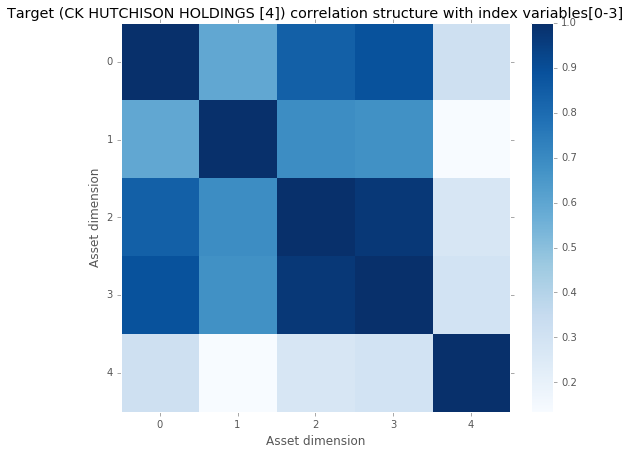

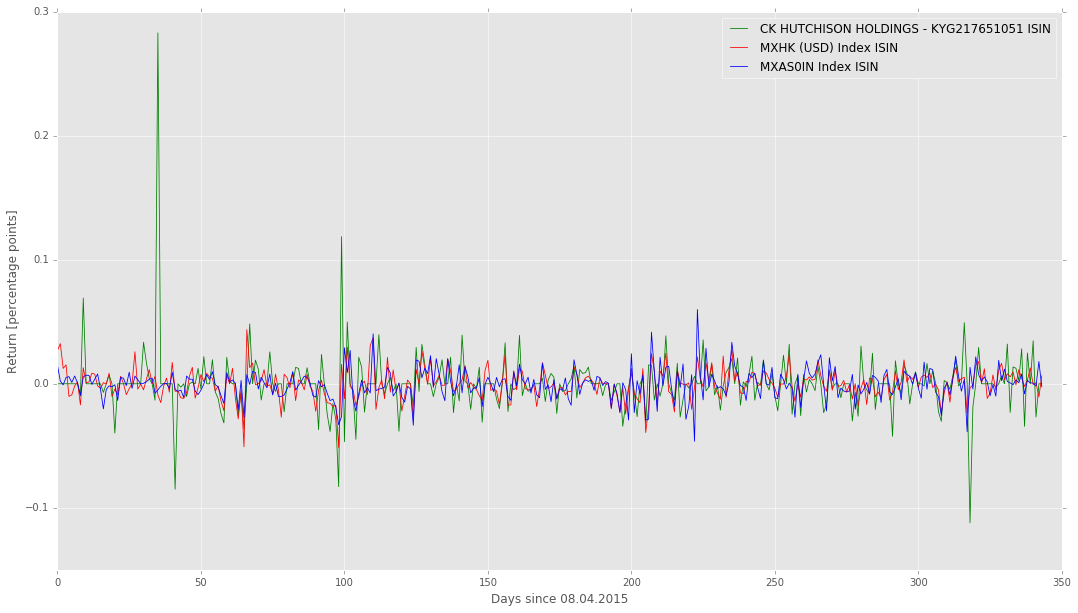

In [16]:
X = ['MXHK (USD) Index ISIN', 'MXAS0IN Index ISIN', 'MMDUAAJ Index ISIN', 'MXASJ Index ISIN']
y = ['KYG217651051 Equity ISIN']

allReturns = pd.concat([tsReturns[X], tsReturns[y]], axis=1)
Sigma = allReturns.cov()
C     = allReturns.corr()

print(C)

print C.columns
ax, cax = plot_matrix(C, (6,6), title='Target (CK HUTCHISON HOLDINGS [4]) correlation structure with index variables[0-3]', cmap=plt.cm.Blues)
ax.set_ylabel('Asset dimension')
ax.set_xlabel('Asset dimension')
plt.savefig("matrixPlot" 
            + "_CKCorrelationStruct_"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

plt.figure(figsize=(18,10), dpi=1000)
line, = plt.plot(range(0, tsReturns[y].size), tsReturns[y], '-', linewidth=.8, color='g',
                label='%s' % ('CK HUTCHISON HOLDINGS - KYG217651051 ISIN'))
line, = plt.plot(range(0, tsReturns[y].size), tsReturns['MXHK (USD) Index ISIN'], '-', linewidth=.8, color='r',
                label='%s' % ('MXHK (USD) Index ISIN'))
line, = plt.plot(range(0, tsReturns[y].size), tsReturns['MXAS0IN Index ISIN'], '-', linewidth=.8, color='b',
                label='%s' % ('MXAS0IN Index ISIN'))
plt.xlabel('Days since 08.04.2015')
plt.ylabel('Return [percentage points]')

plt.legend(loc='upper right')    
plt.savefig("tsPlot" 
            + "_CKApproachOne_"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

In [7]:
tsReturns.index

Index([u'08.04.2015', u'09.04.2015', u'10.04.2015', u'13.04.2015',
       u'14.04.2015', u'15.04.2015', u'16.04.2015', u'17.04.2015',
       u'20.04.2015', u'21.04.2015',
       ...
       u'19.07.2016', u'20.07.2016', u'21.07.2016', u'22.07.2016',
       u'25.07.2016', u'26.07.2016', u'27.07.2016', u'28.07.2016',
       u'29.07.2016', u'01.08.2016'],
      dtype='object', name=u'date', length=344)

## Comments:

->> It is evident that there is a low correlation amongst the target variable and the proposed set of regressors 

->> Identifying information from the Bloomberg repo. was not very good at identifying good proxies for the returns time-series


# Approach 1 - Linear Regression w/ elements of mapping logic and economic intuition
## The simple idea behind this approach is to construct a linear estimator for filling-in missing time-series for stocks within the collateral portfolio.

## Model 1 - Linear regression, saturated model incl.

### ->> MSCI Honk Kong (USD converted) index 

### ->> MSCI Asia Industrial 

### ->> MSCI Asia excl. Japan Mid-Cap

### ->> MSCI Asia excl. Japan Index

[[ 0.46347841 -0.22599821 -0.07359008  0.44241028]]
0.10501564301
Fitted vs. Actual Plot
Resid. Plot


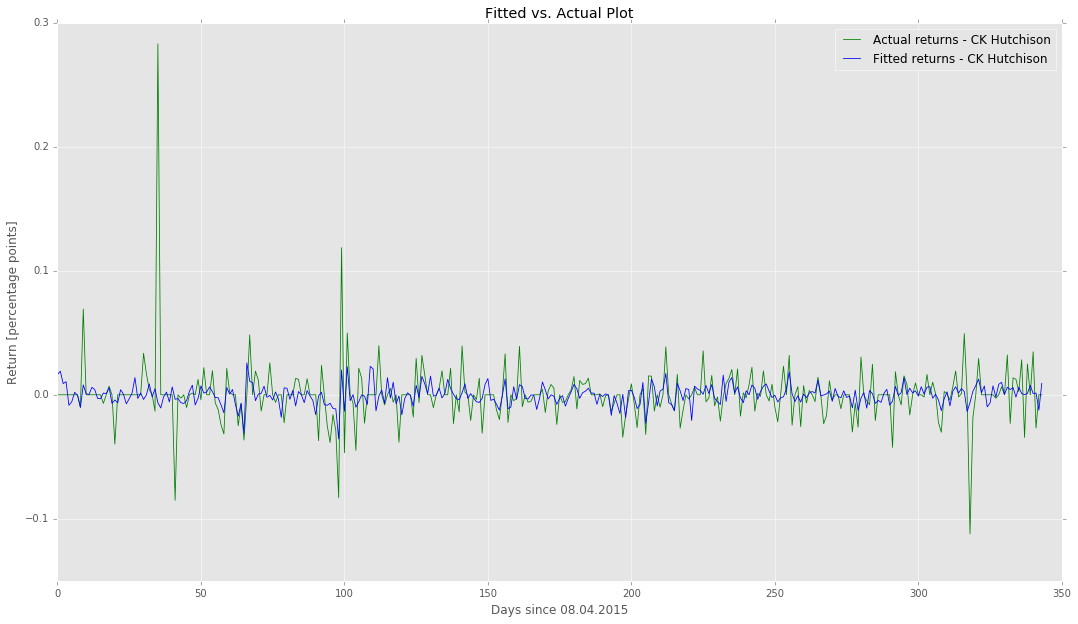

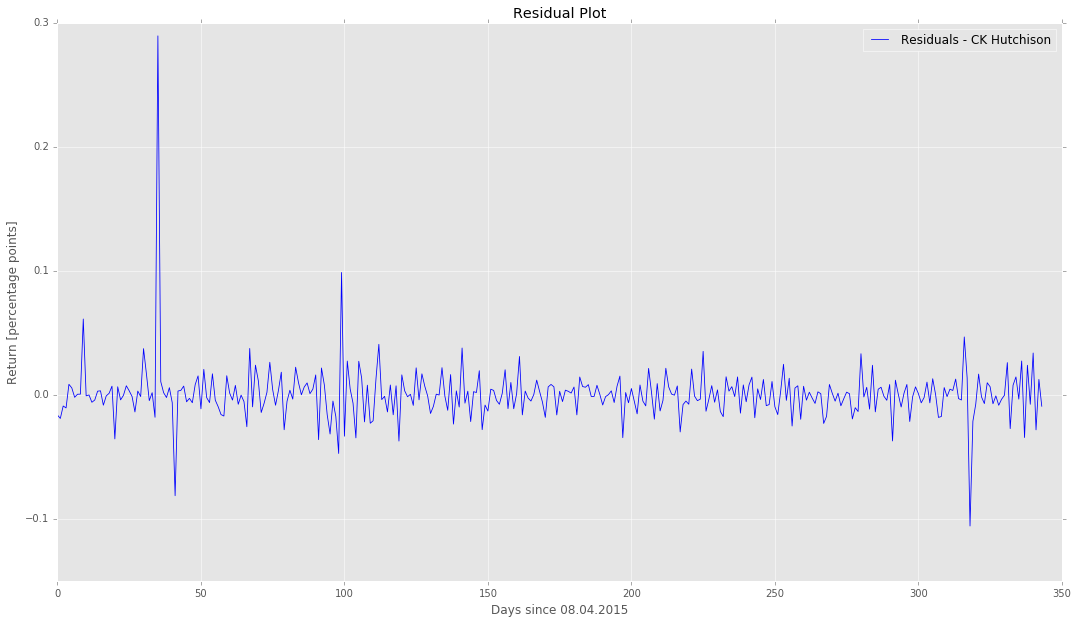

In [20]:
# Regression: Linear Regression - specified based on mapping logic, economic intuition
# Specification y = XB + e
regr = LinearRegression(fit_intercept=False)

# Model 1: All indicators, saturated regression
X = ['MXHK (USD) Index ISIN', 'MXAS0IN Index ISIN', 'MMDUAAJ Index ISIN', 'MXASJ Index ISIN']
y = ['KYG217651051 Equity ISIN']
regr.fit(tsReturns[X], tsReturns[y])
tsPredictData = regr.predict(tsReturns[X])

# Evaluate: Model 1
resid = tsReturns[y] - tsPredictData
rSquared = regr.score(tsReturns[X], tsReturns[y])
print regr.coef_
print rSquared

print "Fitted vs. Actual Plot"
plt.figure(figsize=(18,10), dpi=1000)
line, = plt.plot(range(0, tsReturns[y].size), tsReturns[y], '-', linewidth=.8, color='green', 
                 label='%s' % ('Actual returns - CK Hutchison')) 
line, = plt.plot(range(0, tsReturns[y].size), tsPredictData, '-', linewidth=.8, color='blue', 
                 label='%s' % ('Fitted returns - CK Hutchison'))
plt.xlabel('Days since 08.04.2015')
plt.ylabel('Return [percentage points]')
plt.title('Fitted vs. Actual Plot')
plt.legend(loc='upper right')
plt.savefig("tsPlot" 
            + "_CKApproachTwo_"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

print "Resid. Plot"
plt.figure(figsize=(18,10), dpi=1000)
line, = plt.plot(range(0, tsReturns[y].size), resid, '-', linewidth=.8, color='blue', 
                 label='%s' % ('Residuals - CK Hutchison'))
plt.xlabel('Days since 08.04.2015')
plt.ylabel('Return [percentage points]')
plt.title('Residual Plot')
plt.legend(loc='upper right')
plt.savefig("tsPlot" 
            + "_CKApproachTwo_Resid_"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

### Comments:
 
->> It is obvious that some outliers exist, this may be better solved via the Theil-Senn estimator, see below

->> Residuals seem well behaved, R-squared is low

## Model 2 - Linear regression, specified model incl.

### ->> MSCI Honk Kong (USD converted) index 

### ->> MSCI Asia Industrial 

[[ 0.71879188 -0.15290526]]
0.100160539022
Fitted vs. Actual Plot
Resid. Plot


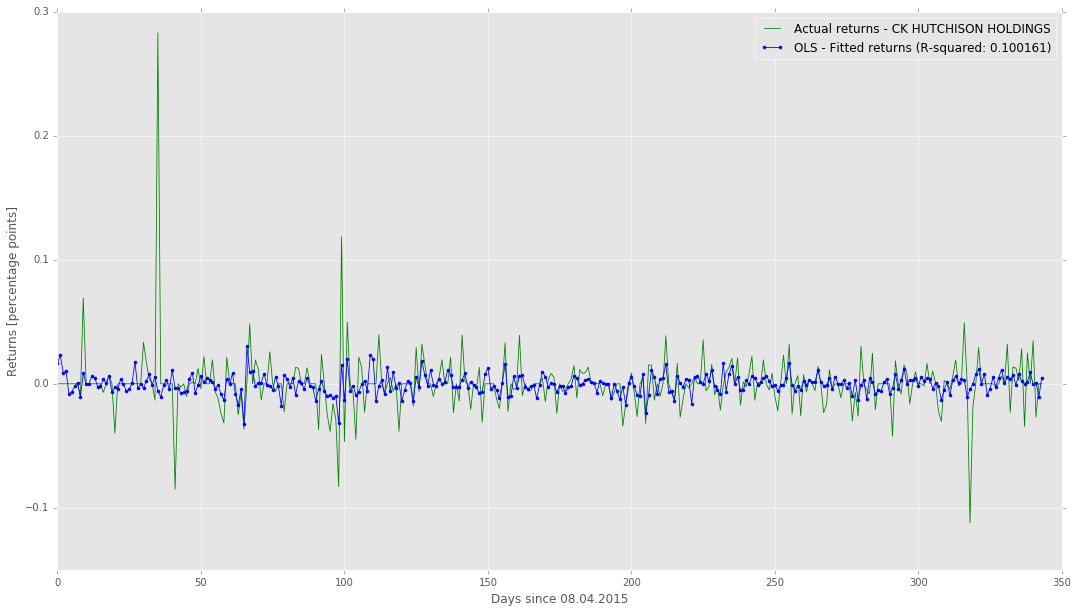

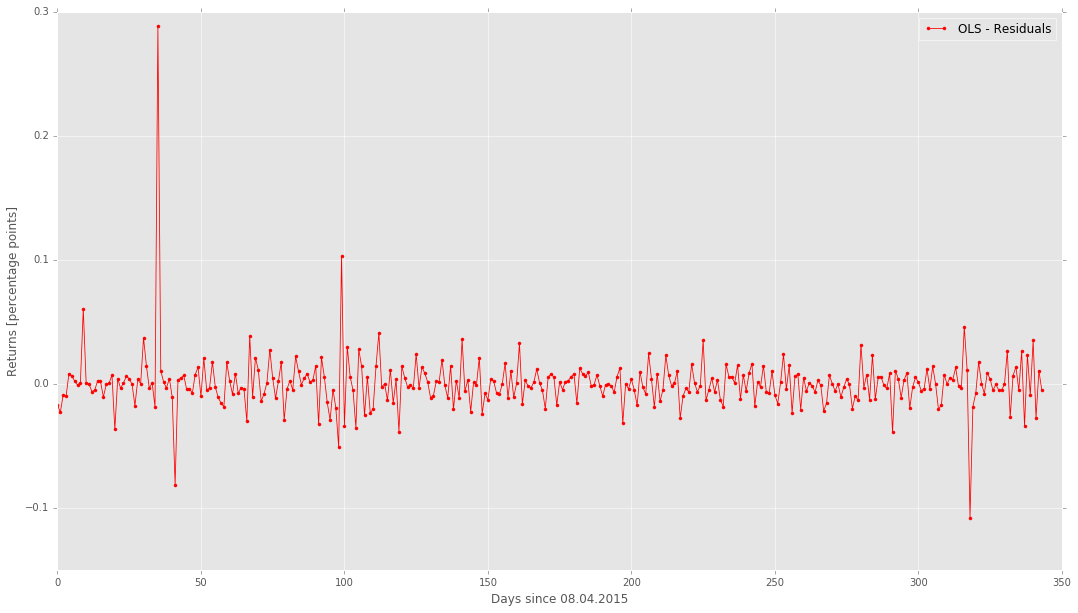

In [45]:
# Model 2: Economic intuition, only selected indicators used 
X = ['MXHK (USD) Index ISIN', 'MXAS0IN Index ISIN']
y = ['KYG217651051 Equity ISIN']
regr.fit(tsReturns[X], tsReturns[y])
tsPredictData = regr.predict(tsReturns[X])

# Evaluate: Model 2
resid = tsReturns[y] - tsPredictData
rSquared = regr.score(tsReturns[X], tsReturns[y])
print regr.coef_
print rSquared

print "Fitted vs. Actual Plot"
plt.figure(figsize=(18,10), dpi=100)
line, = plt.plot(range(0, tsReturns[y].size), tsReturns[y], '-', linewidth=.8, color='green', 
                label='%s' % ('Actual returns - CK HUTCHISON HOLDINGS')) 
line, = plt.plot(range(0, tsReturns[y].size), tsPredictData, '.-', linewidth=.8, color='blue', 
                label='%s (R-squared: %.6f)' % ('OLS - Fitted returns', rSquared))
plt.xlabel('Days since 08.04.2015')
plt.ylabel('Returns [percentage points]')
plt.legend(loc='upper right')    
plt.savefig("tsPlot" 
            + "_CKApproachTwo_SpecModel_"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

print "Resid. Plot"
plt.figure(figsize=(18,10), dpi=100)
line, = plt.plot(range(0, tsReturns[y].size), resid, '.-', linewidth=.8, color='r', 
                 label='%s' % ('OLS - Residuals'))
plt.xlabel('Days since 08.04.2015')
plt.ylabel('Returns [percentage points]')
plt.legend(loc='upper right') 
plt.savefig("tsPlot" 
            + "_CKApproachTwo_SpecModel_Resid_"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

### Comments:

->> It is clear that the ordinary linear regression is useful in capturing behaviour around the mean of the return series, but not the necessary dynamics of the series, even in-sample

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


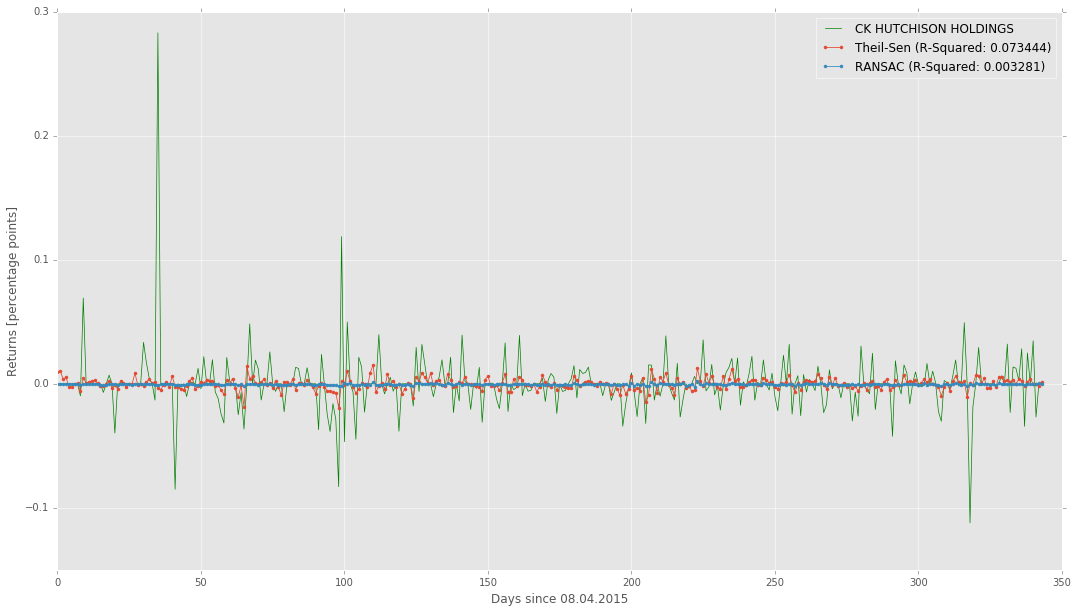

In [52]:
# Model 3: Robust estimators on aforementioned data
X = ['MXHK (USD) Index ISIN', 'MXAS0IN Index ISIN']
y = ['KYG217651051 Equity ISIN']

estimators = [('Theil-Sen', TheilSenRegressor(random_state=42)), 
             ('RANSAC', RANSACRegressor(random_state=42))]

plt.figure(figsize=(18,10), dpi=100)
line, = plt.plot(range(0, tsReturns[y].size), tsReturns[y], '-', linewidth=.7, color='g',
                label='%s' % ('CK HUTCHISON HOLDINGS'))

for name, estimator in estimators:
    estimator.fit(np.asarray(tsReturns[X]), np.asarray(tsReturns[y]))
    tsPredictData = estimator.predict(tsReturns[X])
    rSquared = estimator.score(tsReturns[X], tsReturns[y])
    line, = plt.plot(range(0, tsReturns[y].size), tsPredictData, '.-', linewidth=.8, 
                     label='%s (R-Squared: %.6f)' % (name, rSquared))
    
plt.xlabel('Days since 08.04.2015')
plt.ylabel('Returns [percentage points]')
plt.legend(loc='upper right')    
plt.savefig("tsPlot" 
            + "_CKApproachTwo_Robust_"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

## Comments:

->> Even when accounting for outliers, the problem persists. There is a factor of idiosyncratic volatility that the regressors are not able to pick up. This is true, both in the case of OLS, as well as robust-estimators (RANSAC, Theil-Sen)

->> Proceed with further investigation

# Approach 3 - Lasso Regression with many predictors
## The idea behind the Lasso regression is shrinkage. The full data-set is employed, unecessary parameters are shrunk $\rightarrow 0$ 

->> Lasso 

->> Ridge 

->> ElasticNet 

This is the code-block which prepares the target and training data, functions from dataPreProcess can be used to shape it further and preform cross-validation and OOS testing
~~~~
# Prepare the training data and target
y = ['KYG217651051 Equity ISIN']
X = tsReturns.columns.ravel()
~~~~


In [26]:
less.__len__()

1

                   rss coef_x_1    coef_x_2   coef_x_3   coef_x_4   coef_x_5  \
alpha_1e-15   0.129399        0 -0.00639927  0.0687626  0.0568798 -0.0526065   
alpha_1e-10   0.129399        0 -0.00640006  0.0687605  0.0568785 -0.0526038   
alpha_1e-08     0.1294        0 -0.00647857  0.0685594  0.0567452 -0.0523446   
alpha_1e-05   0.140007        0 -0.00120544          0  0.0383242         -0   
alpha_0.0001   0.18259        0           0          0          0          0   
alpha_0.001   0.203934        0           0          0          0          0   
alpha_0.01    0.203934        0           0          0          0          0   
alpha_1       0.203934        0           0          0          0          0   
alpha_5       0.203934        0           0          0          0          0   
alpha_10      0.203934        0           0          0          0          0   

               coef_x_6   coef_x_7  coef_x_8  coef_x_9    ...    coef_x_80  \
alpha_1e-15  -0.0639327   0.137281  0.182

alpha_1e-15      1
alpha_1e-10      1
alpha_1e-08      1
alpha_1e-05     43
alpha_0.0001    85
alpha_0.001     89
alpha_0.01      89
alpha_1         89
alpha_5         89
alpha_10        89
dtype: int64

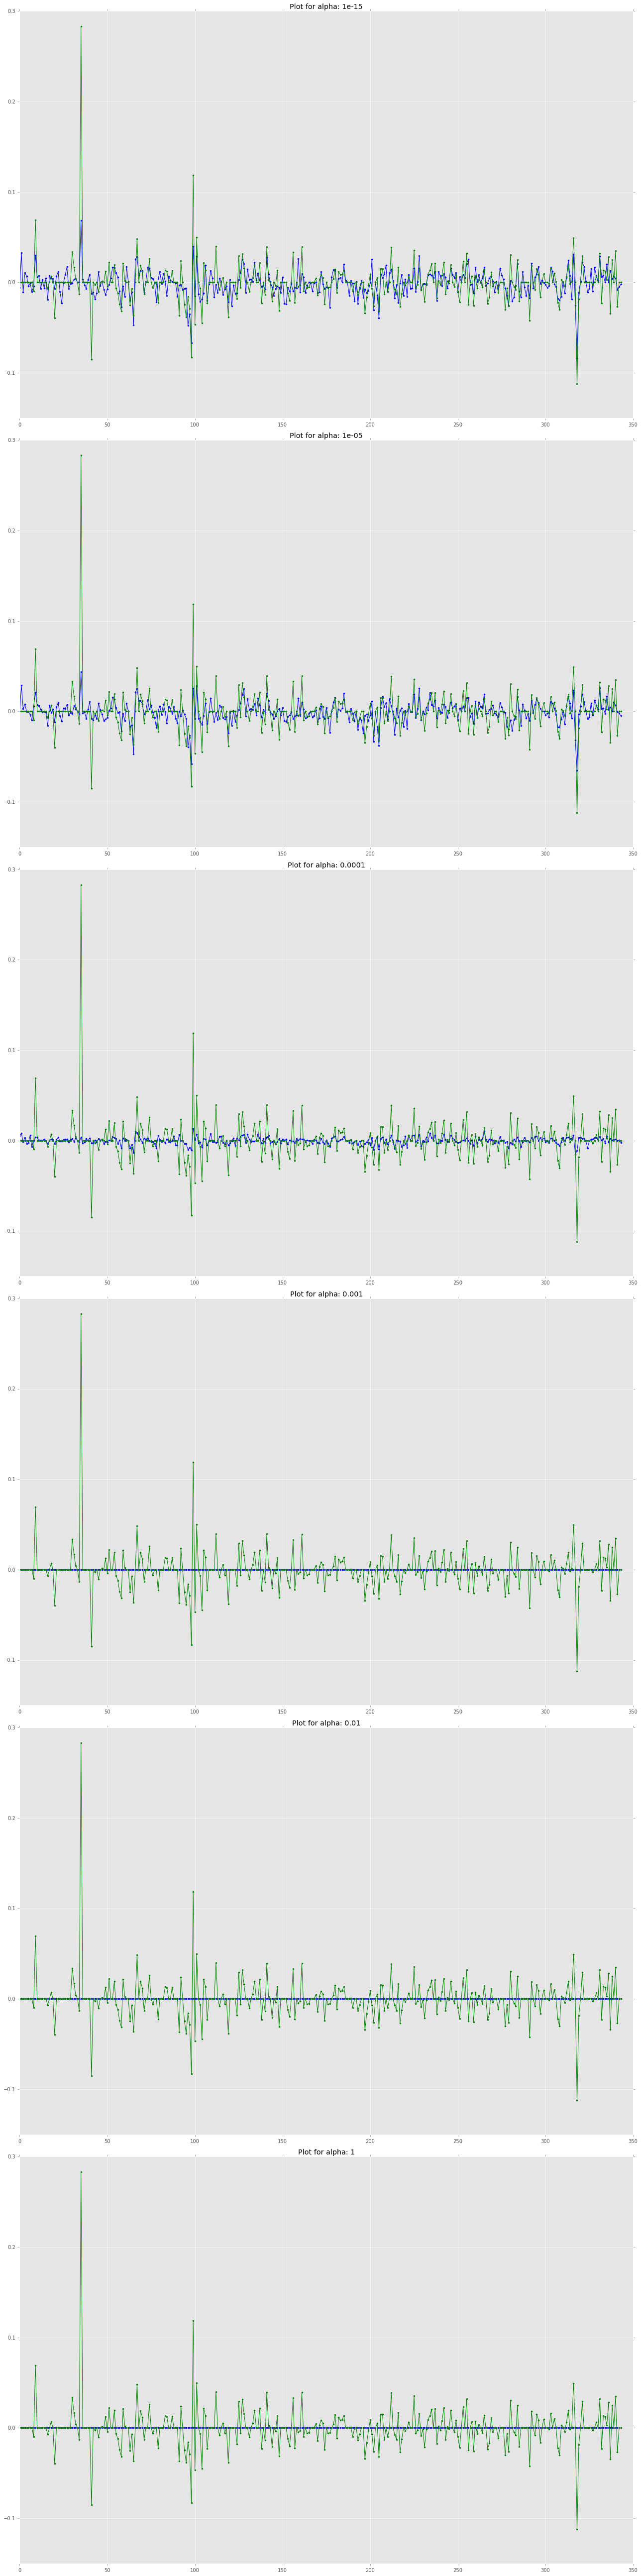

In [27]:
from sklearn.linear_model import Lasso

# Prepare the training data and target
y = ['KYG217651051 Equity ISIN']
X = tsReturns.columns.ravel()
less = ['HKDUSD BGN Curncy ISIN']

# Function that computes set difference
diff = lambda l1,l2: [x for x in l1 if x not in l2]
X = diff(X,y)
X = diff(X, less)

plt.figure(figsize=(18,72), dpi=100)

def lasso_reg(data, X, y, alpha, models_to_plot={}):
    lassoReg = Lasso(alpha=alpha, normalize=True, fit_intercept=False, max_iter=1e5)
    lassoReg.fit(np.asarray(data[X]), np.asarray(data[y]))
    y_pred = lassoReg.predict(np.asarray(data[X]))
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(range(0, tsReturns[y].size), y_pred, 'b.-')
        plt.plot(range(0, tsReturns[y].size), data[y], 'g.-')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    test = np.reshape(data[y].as_matrix(), (data.__len__(),)) - y_pred
    rss = sum(test**2)
    #rss = sum((y_pred-data[y])**2)
    ret = [rss]
    ret.extend([lassoReg.intercept_])
    ret.extend(lassoReg.coef_)
    
    return ret

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

#Initialize the dataframe to store coefficients
col = ['rss'] + ['coef_x_%d'%i for i in range(1,tsReturns.columns.__len__()+1-less.__len__())]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-15:611, 1e-5:612,1e-4:613, 1e-3:614, 1e-2:615, 1:616}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_reg(tsReturns, X, y, alpha_lasso[i], models_to_plot)

print coef_matrix_lasso
coef_matrix_lasso.apply(lambda x: sum(x.values==0), axis=1) 

#lasso_reg(tsReturns, X, y, alpha=1e-5, models_to_plot={1e-5:231})

### Comments:

->> The sensitivity to the parameter $\alpha$ is clear. As $\alpha \rightarrow 0$ we produce results alike those of the OLS regression, and hence risk overfitting. To test whether this is the case cross-validation using SKLearn and sample selection will be performed


9.64208796754e-05
0.00014538431568


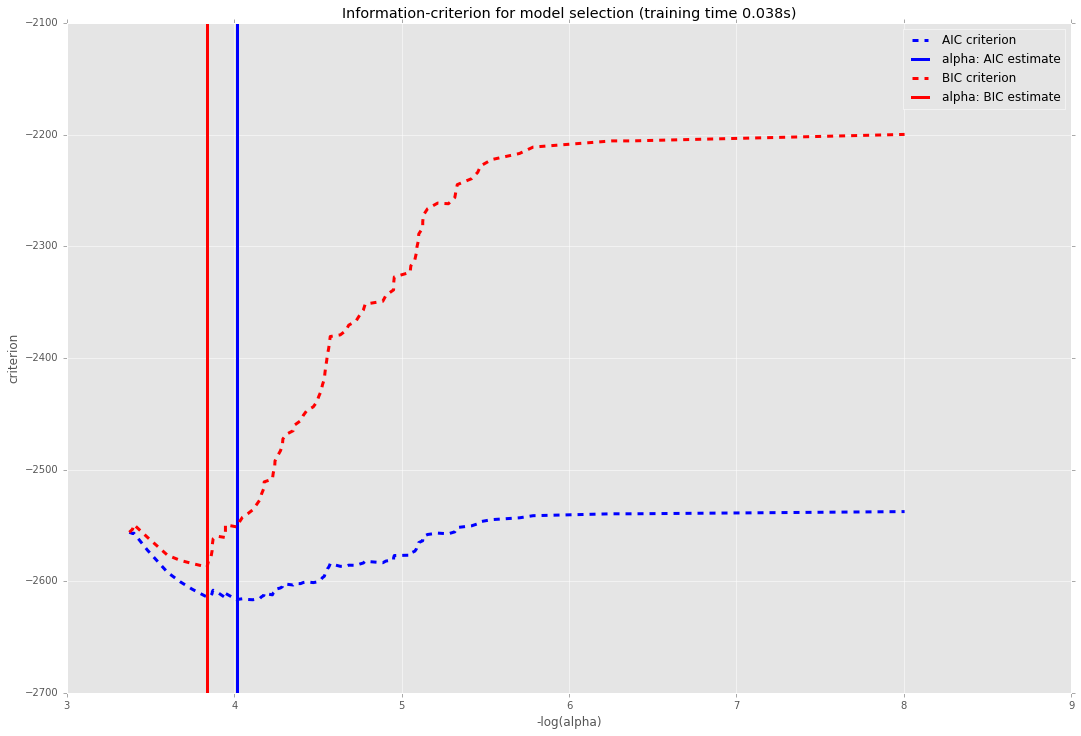

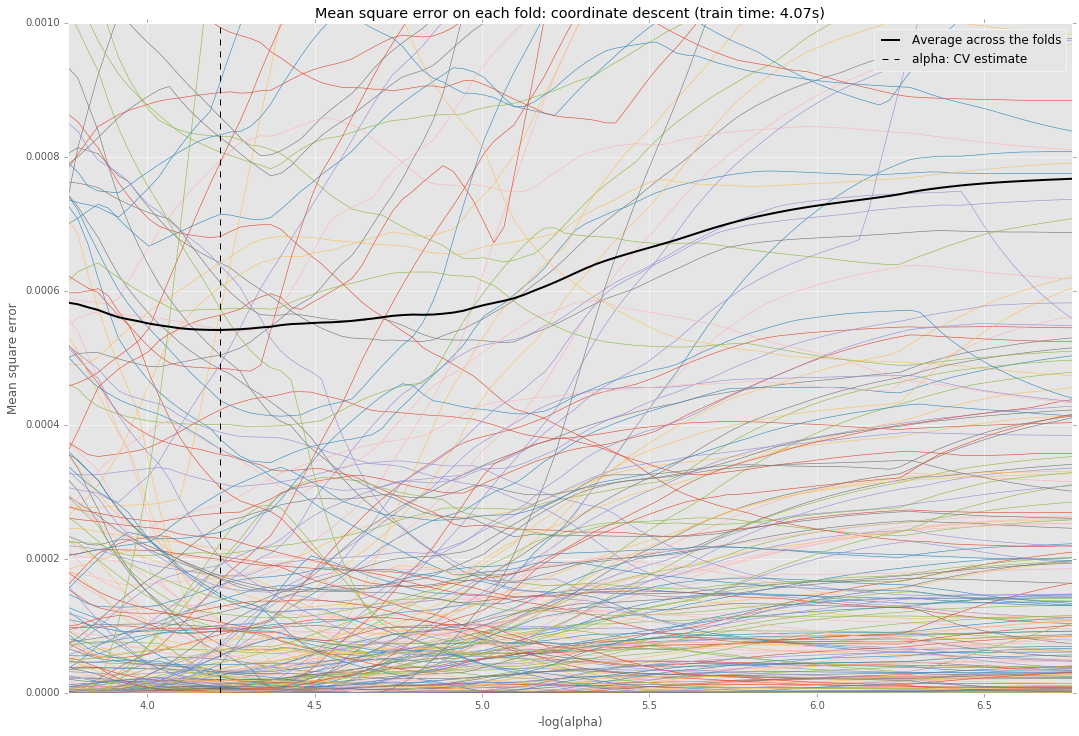

In [56]:
from sklearn.linear_model import LassoCV, LassoLarsIC

# Prepare the training data and target
y = ['KYG217651051 Equity ISIN']
X = tsReturns.columns.ravel()

# Function that computes set difference
diff = lambda l1,l2: [x for x in l1 if x not in l2]
X = diff(X,y)

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(tsReturns[X], np.reshape(tsReturns[y].as_matrix(), (tsReturns.__len__(),)))
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(tsReturns[X], np.reshape(tsReturns[y].as_matrix(), (tsReturns.__len__(),)))
alpha_aic_ = model_aic.alpha_

def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure(figsize=(18,12))
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

# LassoCV: coordinate descent

# Compute paths
t1 = time.time()
model = LassoCV(cv=200).fit(tsReturns[X], np.reshape(tsReturns[y].as_matrix(), (tsReturns.__len__(),)))
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure(figsize=(18,12))
ymin, ymax = 0, 0.001
plt.plot(m_log_alphas, model.mse_path_, '-', linewidth=.6)
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)
 
alphaLassoCV = model.alpha_
print alpha_aic_
print alpha_bic_

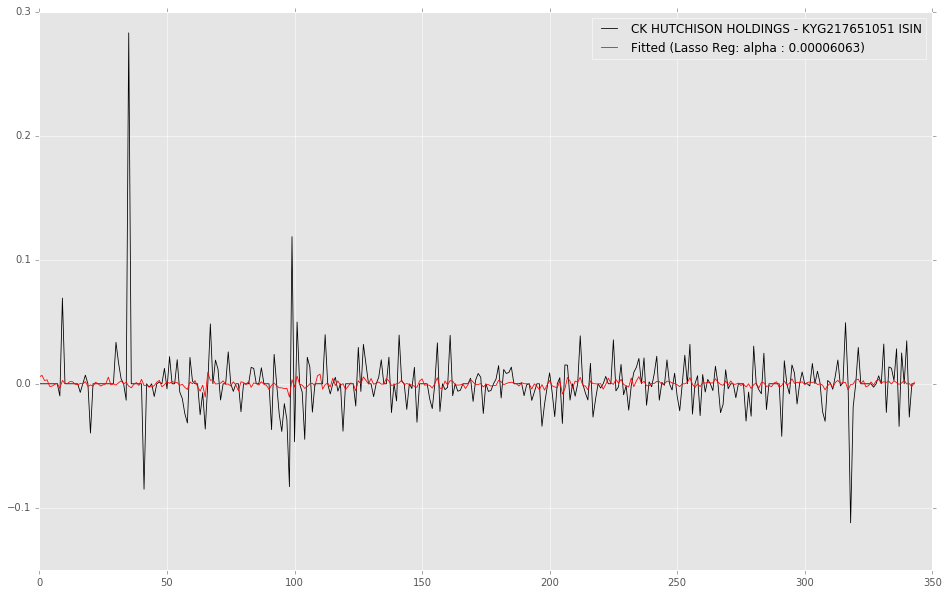

In [230]:
lassoReg = Lasso(alpha=alphaLassoCV, normalize=True, fit_intercept=False)
lassoReg.fit(np.asarray(tsReturns[X]), np.asarray(tsReturns[y]))
y_pred = lassoReg.predict(np.asarray(tsReturns[X]))


plt.figure(figsize=(16,10), dpi=100)
line, = plt.plot(range(0, tsReturns[y].size), tsReturns[y], '-', linewidth=.8, color='black',
                label='%s' % ('CK HUTCHISON HOLDINGS - KYG217651051 ISIN'))
line, = plt.plot(range(0, tsReturns[y].size), y_pred, '-', linewidth=.8, color='red',
                label='%s (Lasso Reg: alpha : %.8f)' % ('Fitted', float(lassoReg.alpha)))
    
plt.legend(loc='upper right')    
plt.show()


In [69]:
sum(lassoReg.coef_ == 0)

77

### Comments:
->> Cross-validation using the internal SKLearn methods yields a far too high value of $\alpha$, which in turn means that the shrinkage penalty function penalizes too many of the coefficients towards zero.  

### Using out-of-sample testing to verify precision of Lasso regression and compare vs. OLS

In [29]:
%matplotlib inline
# coding = utf-8

import sys
sys.path.extend(['/Users/Dim/Desktop/school_folder/masters_thesis/gitCodeRepo/codePython/collateralOptimizer/'])
from dataPreProcess import *
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Using the BBG data, we perform cross-validation 
oosSampleSize = 120

# Prepare data block

# Set the path and filename of the historical data to be used
filePath = "/Users/Dim/Desktop/school_folder/masters_thesis/gitCodeRepo/data/"
fileName = "historicalData_fill_20160809.csv"

# Fetch Data 
dataDict = prepareData(filePath=filePath, fileName=fileName)

#rowCheck = min(min(np.where(dataDict['tfdata'].sum(1) == 0)))
#rowMax   = dataDict['tfdata'].__len__()
#tsMax    = rowMax - rowCheck
tsTraining = fetchDataSubset(dataDict['data'], 
                             dataDict['tfdata'], 
                             dataDict['date'])

tsPredict  = fetchDataSubset(tsTraining['data'], 
                             tsTraining['tfdata'], 
                             tsTraining['date'], 
                             lookbackLength = oosSampleSize)

# Align df's to common date based index
levelDataTraining = pd.concat([tsTraining['data'], tsTraining['date']], axis=1)
levelDataTraining = levelDataTraining.set_index('date')

levelDataPredict = pd.concat([tsPredict['data'], tsPredict['date']], axis=1)
levelDataPredict = levelDataPredict.set_index('date')

# Delete tail-end of training set so that model is unaware of future
levelDataTraining = levelDataTraining.drop(levelDataTraining.index[[range(levelDataTraining.__len__() - levelDataPredict.__len__(),
                                                                         levelDataTraining.__len__())]])

# Adjust "MXHK Index ISIN" index is in HKD, equity is in USD
hkIndex_HKD1 = pd.to_numeric(levelDataTraining['MXHK Index ISIN'])
crcyHKDUSD1  = pd.to_numeric(levelDataTraining['HKDUSD BGN Curncy ISIN'])
hkIndex_HKD2 = pd.to_numeric(levelDataPredict['MXHK Index ISIN'])
crcyHKDUSD2  = pd.to_numeric(levelDataPredict['HKDUSD BGN Curncy ISIN'])

# Apply CCY conversion
hkIndex_USD1 = np.multiply(hkIndex_HKD1, crcyHKDUSD1)
hkIndex_USD1 = hkIndex_USD1.rename("MXHK (USD) Index ISIN")
levelDataTraining = pd.concat([levelDataTraining, hkIndex_USD1], axis=1)
hkIndex_USD2 = np.multiply(hkIndex_HKD2, crcyHKDUSD2)
hkIndex_USD2 = hkIndex_USD2.rename("MXHK (USD) Index ISIN")
levelDataPredict = pd.concat([levelDataPredict, hkIndex_USD2], axis=1)

# Calculate relative returns R_t = (X_t / X_t-1) - 1 ->> For now use pandas built-in function
# tsDataReturns = tsData.pct_change(1) verified to produce consistent results with above
# returns = (vfiax_monthly.open - vfiax_monthly.open.shift(1))/vfiax_monthly.open
retDataTraining = levelDataTraining.apply(pd.to_numeric)
retDataTraining = retDataTraining.pct_change()
retDataTraining = retDataTraining.dropna(axis=0)

retDataPredict = levelDataPredict.apply(pd.to_numeric)
retDataPredict = retDataPredict.pct_change()
retDataPredict = retDataPredict.dropna(axis=0)


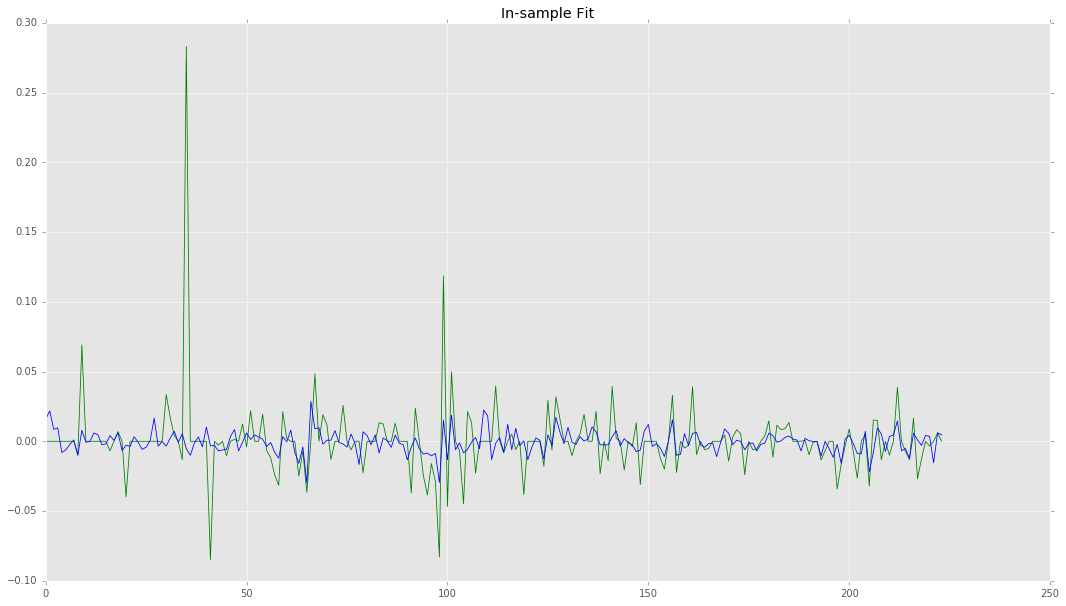

Beta      : 1.36558
Intercept : -0.00120 



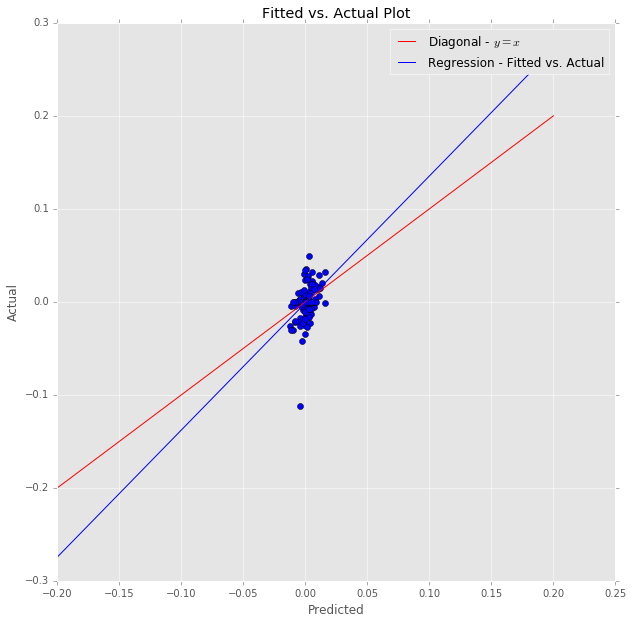

In [50]:
# Regression: Linear Regression - OOS test
# Specification y = XB + e
regr = LinearRegression(fit_intercept = False)

# Model 1: All indicators, saturated regression
X = ['MXHK (USD) Index ISIN', 'MXAS0IN Index ISIN']
y = ['KYG217651051 Equity ISIN']
regr.fit(retDataTraining[X], retDataTraining[y])
retFitted = regr.predict(retDataPredict[X])

# Evaluate: Model 1
rSquared = regr.score(retDataTraining[X], retDataTraining[y])
evalRegr = LinearRegression(fit_intercept = True)
evalRegr.fit(retFitted, retDataPredict[y])

xLin = np.linspace(-0.2, 0.2, retDataPredict.__len__())
yFunc = xLin
yFuncFitted = float(evalRegr.coef_) * xLin + float(evalRegr.intercept_)

plt.figure(figsize=(18,10), dpi=100)
line, = plt.plot(range(0, retDataTraining[y].size), retDataTraining[y], '-', linewidth=.8, color='green') 
line, = plt.plot(range(0, retDataTraining[y].size), regr.predict(retDataTraining[X]), '-', linewidth=.8, color='blue')
plt.title('In-sample Fit')
plt.show()

print 'Beta      : %.5f' % (float(evalRegr.coef_))
print 'Intercept : %.5f \n' % float(evalRegr.intercept_)
# "Fitted vs. Actual Plot"
plt.figure(figsize=(10,10), dpi=100)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Fitted vs. Actual Plot')
plt.plot(retFitted, retDataPredict[y], 'bo')
plt.plot(xLin, yFunc, 'r-', label='Diagonal - $y=x$')
plt.plot(xLin, yFuncFitted, 'b-', label='Regression - Fitted vs. Actual')
plt.legend(loc='upper right')    
plt.savefig("diagonalPlot" 
            + "_CKApproachTwo_SpecModel"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

Beta      : 0.92997
Intercept : -0.00106 



77

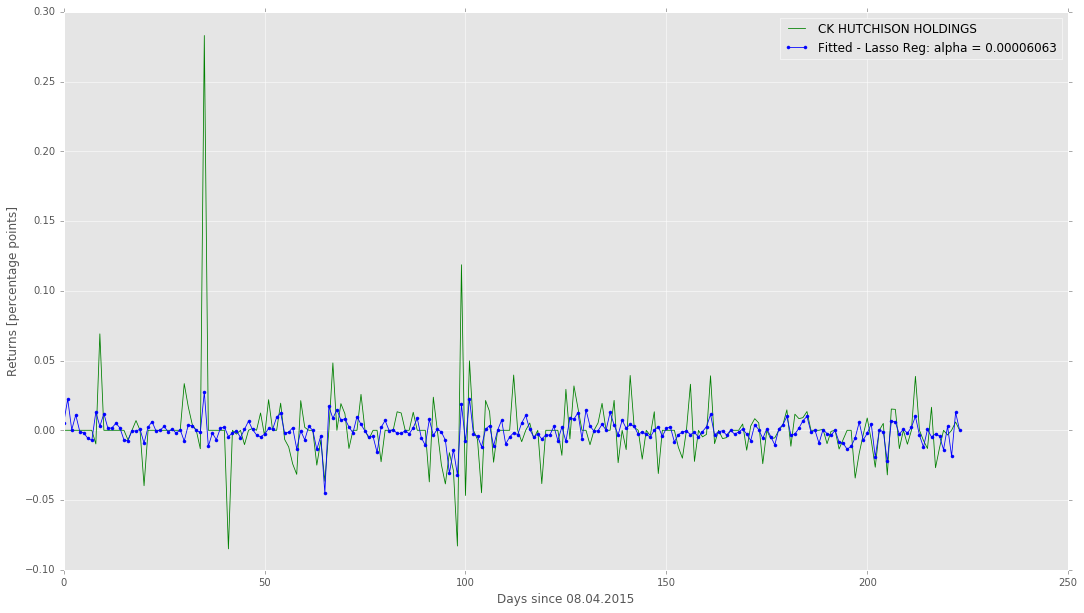

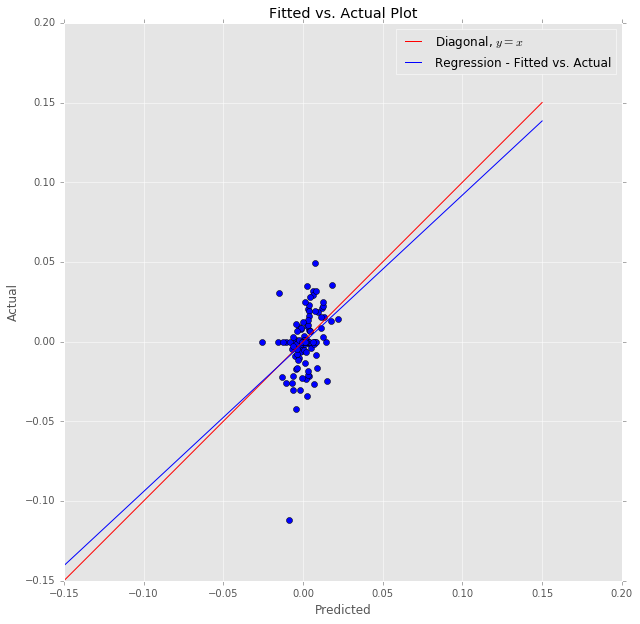

In [71]:
# Regression: Lasso Regression - OOS test
from sklearn.linear_model import Lasso

# Prepare the training data and target
y    = ['KYG217651051 Equity ISIN']
less = ['MXHK Index ISIN']
X    = retDataTraining.columns.ravel()

# Function that computes set difference
diff = lambda l1,l2: [x for x in l1 if x not in l2]
X = diff(X,y)
X = diff(X,less)

# alpha is taken from LassoVC example from above
lassoReg = Lasso(alpha=6.06317158591e-05, normalize=True, fit_intercept=False, max_iter=1e6)
lassoReg.fit(np.asarray(retDataTraining[X]), np.asarray(retDataTraining[y]))
y_pred = lassoReg.predict(np.asarray(retDataPredict[X]))

evalRegr = LinearRegression(fit_intercept = True)
evalRegr.fit(y_pred.reshape(-1,1), 
             np.asarray(retDataPredict[y]).reshape(-1,1))
print 'Beta      : %.5f' % (float(evalRegr.coef_))
print 'Intercept : %.5f \n' % float(evalRegr.intercept_)

xLin = np.linspace(-0.15, 0.15, retDataPredict.__len__())
yFunc = xLin
yFuncFitted = float(evalRegr.coef_) * xLin + float(evalRegr.intercept_)

plt.figure(figsize=(18,10), dpi=1000)
line, = plt.plot(range(0, retDataTraining[y].size), retDataTraining[y], '-', linewidth=.8, color='g',
                label='%s' % ('CK HUTCHISON HOLDINGS'))
line, = plt.plot(range(0, retDataTraining[y].size), lassoReg.predict(np.asarray(retDataTraining[X])), 'b.-', linewidth=.8,
                label='%s %.8f' % ('Fitted - Lasso Reg: alpha =', float(lassoReg.alpha)))
plt.ylabel('Returns [percentage points]')
plt.xlabel('Days since 08.04.2015')
plt.legend(loc='upper right')    
plt.savefig("tsPlot" 
            + "_CKApproachThree_lasso"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

# "Fitted vs. Actual Plot"
plt.figure(figsize=(10,10), dpi=1000)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Fitted vs. Actual Plot')
plt.plot(y_pred, retDataPredict[y], 'bo')
plt.plot(xLin, yFunc, 'r-', label='Diagonal, $y=x$')
plt.plot(xLin, yFuncFitted, 'b-', label='Regression - Fitted vs. Actual')
plt.legend(loc='upper right') 
plt.savefig("diagonalPlot" 
            + "_CKApproachThree_lasso"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

sum(lassoReg.coef_ == 0)

In [177]:
print levelDataPredict.index
print levelDataTraining.index

Index([u'16.02.2016', u'17.02.2016', u'18.02.2016', u'19.02.2016',
       u'22.02.2016', u'23.02.2016', u'24.02.2016', u'25.02.2016',
       u'26.02.2016', u'29.02.2016',
       ...
       u'19.07.2016', u'20.07.2016', u'21.07.2016', u'22.07.2016',
       u'25.07.2016', u'26.07.2016', u'27.07.2016', u'28.07.2016',
       u'29.07.2016', u'01.08.2016'],
      dtype='object', name=u'date', length=120)
Index([u'07.04.2015', u'08.04.2015', u'09.04.2015', u'10.04.2015',
       u'13.04.2015', u'14.04.2015', u'15.04.2015', u'16.04.2015',
       u'17.04.2015', u'20.04.2015',
       ...
       u'02.02.2016', u'03.02.2016', u'04.02.2016', u'05.02.2016',
       u'08.02.2016', u'09.02.2016', u'10.02.2016', u'11.02.2016',
       u'12.02.2016', u'15.02.2016'],
      dtype='object', name=u'date', length=225)


### Interrim Conclusions: 
->> The OLS regression provides weak in-sample fit, and surprising results in the OOS test
->> The Lasso regression with calibrated $\alpha$ parameter provides a better in-sample fit and does well in the OOS test.

# Approach 4 - Back-filling time series using MLE
### The idea is to use: S. Page [2013] - How to combine Long and Short Return Histories Efficiently


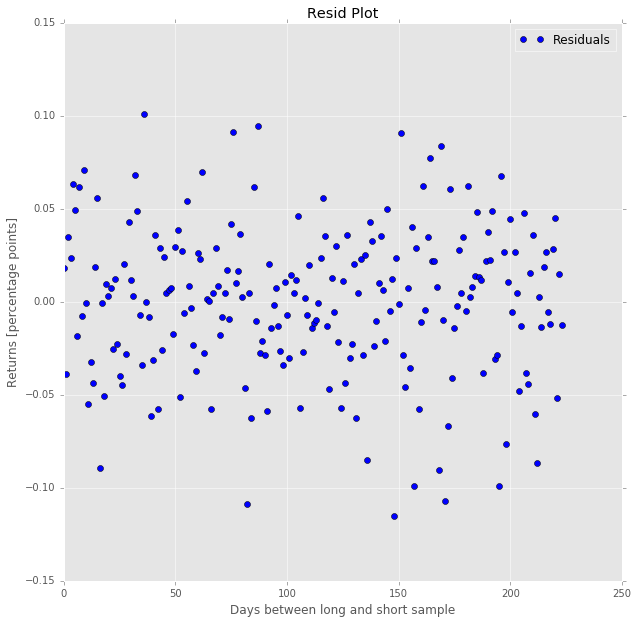

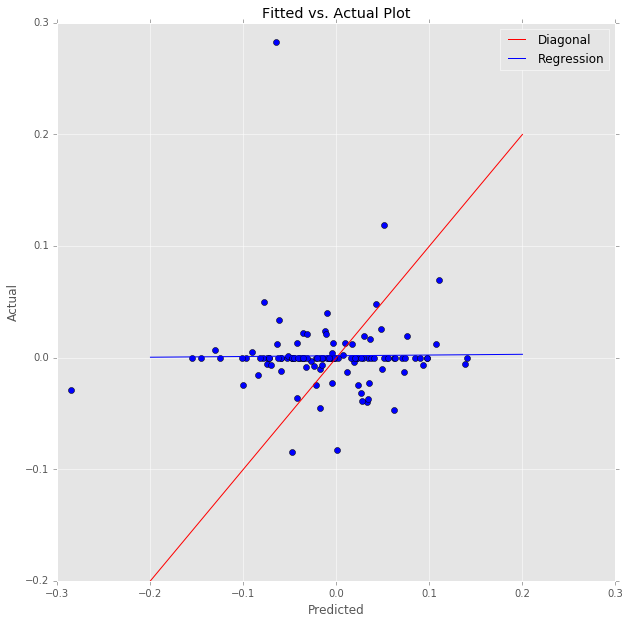

In [108]:
# Prepare data block
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression

# Set the path and filename of the historical data to be used
filePath = "/Users/Dim/Desktop/school_folder/masters_thesis/gitCodeRepo/data/"
fileName = "historicalData_fill_20160809.csv"

# Fetch Data 
dataDict = prepareData(filePath=filePath, fileName=fileName)

## Some back testing 
# store actual data
start = 1895
end = 2015
y = ['KYG217651051 Equity ISIN']
actual=dataDict['data'][y][start:end]
# remove some data
dataDict['data'].loc[dataDict['data'].index[start:end], y] = '#VALUE'
dataDict['tfdata'].loc[dataDict['tfdata'].index[start:end], y] = True
# confirm data change 
#print dataDict['data'].loc[:, y]
#print dataDict['tfdata'].loc[:, y]

# Obtain descriptives 
colsMissing = np.where(dataDict['tfdata'].sum(0) > 0)
colsMissingLength = dataDict['tfdata'].sum(0)[(dataDict['tfdata'].sum(0)).index[dataDict['tfdata'].sum(0) > 0]]

# Some basic data manipulation
a=np.asarray(colsMissingLength.index)
b=np.asarray(colsMissing)
a=np.reshape(a, (1,max(colsMissing).__len__()))
c=np.concatenate((a,b,)).T
c=pd.DataFrame(c)
c.columns = ['ISIN', 'numeric_ref']
c=c.set_index('ISIN')
d=pd.concat([c, colsMissingLength], axis=1)
d.columns = ['numeric_ref', 'numeric_length']
d=d.sort_values(by='numeric_length', ascending = True)
# EXAMPLE: access via key - print d.loc['CNE100000FF3 Equity ISIN']

# Function that computes set difference
diff = lambda l1,l2: [x for x in l1 if x not in l2]

## Prepare the full-information data and target data, excl. additional data used for reg. above (eps)
#y = ['CH0012032113 Equity ISIN']
x = diff(dataDict['data'].columns.ravel(), np.asarray(d.index))
eps = ['MXAS0IN Index ISIN', 'MXHK Index ISIN', 'MMDUAAJ Index ISIN', 'MXASJ Index ISIN', 'HKDUSD BGN Curncy ISIN']
x = diff(x, eps)

## Subsets 
X_tau = dataDict['data'][x].drop(dataDict['data'][x].index[[range(0, d.loc[y].numeric_length)]])
Y_tau = dataDict['data'][y].drop(dataDict['data'][y].index[[range(0, d.loc[y].numeric_length)]])
X_T = dataDict['data'][x]
date_tau = dataDict['date'].drop(dataDict['date'].index[[range(0, d.loc[y].numeric_length)]])
date_T = dataDict['date']

## Dated subsets
X_tau = pd.concat([X_tau, date_tau], axis=1)
X_tau = X_tau.set_index('date')
Y_tau = pd.concat([Y_tau, date_tau], axis=1)
Y_tau = Y_tau.set_index('date')
X_T = pd.concat([X_T, date_T], axis=1)
X_T = X_T.set_index('date')

## Compute returns 
X_tau = X_tau.apply(pd.to_numeric)
X_tau = X_tau.pct_change()
X_tau = X_tau.dropna(axis=0)

Y_tau = Y_tau.apply(pd.to_numeric)
Y_tau = Y_tau.pct_change()
Y_tau = Y_tau.dropna(axis=0)

X_T = X_T.apply(pd.to_numeric)
X_T = X_T.pct_change()
X_T = X_T.dropna(axis=0)

## Additional
XY_tau = pd.concat([X_tau, Y_tau], axis = 1, join = 'outer') #  FIXED
#X_T_less_tau = X_T.drop(X_T.index[[range(d.loc[y].numeric_length, X_T.shape[0])]])

# Copy Matlab implementation 
cov_mat_tau = XY_tau.cov().values
Cov_XY_tau = np.reshape(((cov_mat_tau[1,:])[1:cov_mat_tau.__len__()]), (cov_mat_tau.__len__()-1, 1))
beta = np.dot(inv(X_tau.cov().values), Cov_XY_tau)

## Compute matrices - mean step (u)
mu_X_tau = np.mean(X_tau.values, axis = 0)
mu_X_T = np.mean(X_T.values, axis = 0)
mu_Y_tau = np.mean(Y_tau.values, axis = 0)
# Reshape arrays to conform to correct sizes for matrix multiplication 
mu_X_tau = np.reshape(mu_X_tau, (mu_X_tau.__len__(), 1))
mu_X_T = np.reshape(mu_X_T, (mu_X_T.__len__(), 1))
mu_Y_tau = np.reshape(mu_Y_tau, (mu_Y_tau.__len__(), 1))
# Compute mean vector for missing time-series in long sample 
mu_Y_T = mu_Y_tau + np.dot(np.transpose(beta), (mu_X_T - mu_X_tau))
X_T_mean_correc = np.transpose(np.repeat(mu_X_T, repeats=X_T.shape[0], axis=1))

## Compute matrices - variance step (S)
S_Y_tau = Y_tau.cov().values
S_X_tau = X_tau.cov().values
S_X_T = X_T.cov().values
S_Y_T = S_Y_tau + np.dot(beta.transpose(), np.dot((S_X_T - S_X_tau), beta))
Cov_YX_T = (Cov_XY_tau.transpose() + np.dot(beta.transpose(), (S_X_T - S_X_tau).transpose())).transpose()

## Compute missing data estimates 
E_Y = mu_Y_T + np.dot(np.dot(Cov_YX_T.transpose(), inv(S_X_T)), np.transpose(X_T - X_T_mean_correc))

## Bootstrapping procedure
# obtain residuals from in-sample fitting 
resid_tau = np.array(Y_tau.values) - np.reshape(np.asarray(E_Y[0])[end:E_Y[0].__len__()], 
                                                (np.asarray(E_Y[0])[end:E_Y[0].__len__()].shape[0],1))
# adjust predicted values with random "noise" from in-sample residuals
E_Y_boot = np.array(E_Y[0])[start+1:end] + np.random.choice(a=resid_tau.flatten(), 
                                                            size=np.array(E_Y[0])[start+1:end].__len__(), 
                                                            replace=True)

# "Fitted vs. Actual Plot"
plt.figure(figsize=(10,10), dpi=1000)
plt.title('Resid Plot')
plt.plot(range(0, resid_tau.__len__()), resid_tau, 'bo', 
         label='%s' % ('Residuals'))
plt.ylabel('Returns [percentage points]')
plt.xlabel('Days between long and short sample')
plt.legend(loc='upper right')    
plt.savefig("residPlot" 
            + "_CKApproachFour_mle"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')
         
## Evaluate results via regression & OOS plots
pred_T_less_tau = np.array(E_Y[0])[start+1:end]
actual = actual.apply(pd.to_numeric)
actual = actual.pct_change()
actual = actual.dropna(axis=0)

evalRegr = LinearRegression(fit_intercept = True)
evalRegr.fit(pred_T_less_tau.reshape(-1,1), 
             np.asarray(actual).reshape(-1,1))

xLin = np.linspace(-0.20, 0.20, pred_T_less_tau.__len__())
yFuncFitted = float(evalRegr.coef_) * xLin + float(evalRegr.intercept_)
yFunc = xLin

# "Fitted vs. Actual Plot"
plt.figure(figsize=(10,10), dpi=1000)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Fitted vs. Actual Plot')
plt.plot(pred_T_less_tau, actual, 'bo')
plt.plot(xLin, yFunc, 'r-', label='Diagonal')
plt.plot(xLin, yFuncFitted, 'b-', label='Regression')
plt.legend(loc='upper right')    
plt.savefig("diagonalPlot" 
            + "_CKApproachFour_mle"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')


In [2]:
## Without backtest
# Prepare data block
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression

# Lambda function that computes set difference
diff = lambda l1,l2: [x for x in l1 if x not in l2]

# Set the path and filename of the historical data to be used
filePath = "/Users/Dim/Desktop/school_folder/masters_thesis/gitCodeRepo/data/"
fileName = "historicalData_fill_20160809.csv" 

# Fetch Data 
dataDict = prepareData(filePath=filePath, fileName=fileName) 

# Obtain descriptives 
colsMissing = np.where(dataDict['tfdata'].sum(0) > 0)
colsMissingLength = dataDict['tfdata'].sum(0)[(dataDict['tfdata'].sum(0)).index[dataDict['tfdata'].sum(0) > 0]]

# Some basic data manipulation
a=np.asarray(colsMissingLength.index)
b=np.asarray(colsMissing)
a=np.reshape(a, (1,max(colsMissing).__len__()))
c=np.concatenate((a,b,)).T
c=pd.DataFrame(c)
c.columns = ['ISIN', 'numeric_ref']
c=c.set_index('ISIN')
d=pd.concat([c, colsMissingLength], axis=1)
d.columns = ['numeric_ref', 'numeric_length']
d=d.sort_values(by='numeric_length', ascending = True)
# EXAMPLE: access via key - print d.loc['CNE100000FF3 Equity ISIN']


# Adjust columns (X)
x   = diff(dataDict['data'].columns.ravel(), np.asarray(d.index))
eps = ['MXAS0IN Index ISIN', 'MXHK Index ISIN', 'MMDUAAJ Index ISIN', 'MXASJ Index ISIN', 'HKDUSD BGN Curncy ISIN']
x   = diff(x, eps)

# Dated df (X)
X = dataDict['data'][x]
X = pd.concat([X, dataDict['date']], axis=1)
X = X.set_index('date')

# Compute returns
X = X.apply(pd.to_numeric)
X = X.pct_change()
X = X.dropna(axis=0)

# function independentBackFiller
# @param y: target series to be backfilled i.e. 'CNE100000FF3 Equity ISIN'
# @param d: the df containing qualitative/quantitative information on the short history time-series i.e. pd.df
# @param dataDict: the dictionary containing the price data set with keys 'data', 'tfdata', 'dates'
def independentBackFiller(y, d, dataDict):
    ## Parameterize backFiller
    # Prepare the full-information data and target data, excl. additional data used for reg. above (eps)
    x   = diff(dataDict['data'].columns.ravel(), np.asarray(d.index))
    eps = ['MXAS0IN Index ISIN', 'MXHK Index ISIN', 'MMDUAAJ Index ISIN', 'MXASJ Index ISIN', 'HKDUSD BGN Curncy ISIN']
    x   = diff(x, eps)
    lenMissing = d.loc[y, 'numeric_length']
    
    ## Subsets 
    X_tau = dataDict['data'][x].drop(dataDict['data'][x].index[[range(0, d.loc[y].numeric_length)]])
    Y_tau = dataDict['data'][y].drop(dataDict['data'][y].index[[range(0, d.loc[y].numeric_length)]])
    X_T = dataDict['data'][x]
    date_tau = dataDict['date'].drop(dataDict['date'].index[[range(0, d.loc[y].numeric_length)]])
    date_T = dataDict['date']

    ## Dated subsets
    X_tau = pd.concat([X_tau, date_tau], axis=1)
    X_tau = X_tau.set_index('date')
    Y_tau = pd.concat([Y_tau, date_tau], axis=1)
    Y_tau = Y_tau.set_index('date')
    X_T = pd.concat([X_T, date_T], axis=1)
    X_T = X_T.set_index('date')

    ## Compute returns 
    X_tau = X_tau.apply(pd.to_numeric)
    X_tau = X_tau.pct_change()
    X_tau = X_tau.dropna(axis=0)

    Y_tau = Y_tau.apply(pd.to_numeric)
    Y_tau = Y_tau.pct_change()
    Y_tau = Y_tau.dropna(axis=0)

    X_T = X_T.apply(pd.to_numeric)
    X_T = X_T.pct_change()
    X_T = X_T.dropna(axis=0)

    ## Additional
    XY_tau = pd.concat([X_tau, Y_tau], axis = 1, join = 'outer') #  FIXED

    # Copy Matlab implementation 
    cov_mat_tau = XY_tau.cov().values
    Cov_XY_tau  = np.reshape(((cov_mat_tau[1,:])[1:cov_mat_tau.__len__()]), (cov_mat_tau.__len__()-1, 1))
    beta        = np.dot(inv(X_tau.cov().values), Cov_XY_tau)

    ## Compute matrices - mean step (u)
    mu_X_tau = np.mean(X_tau.values, axis = 0)
    mu_X_T   = np.mean(X_T.values, axis = 0)
    mu_Y_tau = np.mean(Y_tau.values, axis = 0)
    # Reshape arrays to conform to correct sizes for matrix multiplication 
    mu_X_tau = np.reshape(mu_X_tau, (mu_X_tau.__len__(), 1))
    mu_X_T   = np.reshape(mu_X_T, (mu_X_T.__len__(), 1))
    mu_Y_tau = np.reshape(mu_Y_tau, (mu_Y_tau.__len__(), 1))
    # Compute mean vector for missing time-series in long sample 
    mu_Y_T = mu_Y_tau + np.dot(np.transpose(beta), (mu_X_T - mu_X_tau))
    X_T_mean_correc = np.transpose(np.repeat(mu_X_T, repeats=X_T.shape[0], axis=1))

    ## Compute matrices - variance step (S)
    S_Y_tau  = Y_tau.cov().values
    S_X_tau  = X_tau.cov().values
    S_X_T    = X_T.cov().values
    S_Y_T    = S_Y_tau + np.dot(beta.transpose(), np.dot((S_X_T - S_X_tau), beta))
    Cov_YX_T = (Cov_XY_tau.transpose() + np.dot(beta.transpose(), (S_X_T - S_X_tau).transpose())).transpose()

    ## Compute missing data estimates 
    E_Y = mu_Y_T + np.dot(np.dot(Cov_YX_T.transpose(), inv(S_X_T)), np.transpose(X_T - X_T_mean_correc))

    ## Bootstrapping procedure
    # obtain residuals from in-sample fitting
    # lenMissing = d.loc[y, 'numeric_length']
    E_Y_tau    = np.reshape(E_Y[0][lenMissing:E_Y[0].__len__()], 
                            (E_Y[0][lenMissing:E_Y[0].__len__()].shape[0], 1))
    resid_tau  = np.array(Y_tau.values) - E_Y_tau

    # adjust predicted values with random "noise" from in-sample residuals
    E_Y_boot = np.array(E_Y[0])[0:lenMissing] + np.random.choice(a = resid_tau.flatten(), 
                                                                size = np.array(E_Y[0])[0:lenMissing].__len__(), 
                                                                replace = True)
    
    # Reconstruct full series i.e. Y_T 
    Y_T = pd.DataFrame(data = np.concatenate((E_Y_boot, Y_tau.values.flatten()), axis=0), 
                       index = X_T.index, 
                       columns = [y])
    
    ## Note: 
    ## ->> The full sample prediction (E_Y) does not contain bootstrapping of errors 
    ## from the so called short sample (tau)
    ## ->> The short sample prediction (E_Y_boot) contains the bootstrapping of errors 
    ## from the so called full sample (T)
    ## ->> The backfilled time-series is contained in (Y_T) 
    return {'fullSamplePred': E_Y, 'smallSamplePred': E_Y_boot, 'backfilledSeries': Y_T}

## Run backfiller for all missing time-series
for isin in d.index:
    temp = independentBackFiller(y = isin, 
                                 d = d, 
                                 dataDict = dataDict)
    X = pd.concat([X, temp['backfilledSeries']], axis = 1)



NameError: name 'plot_matrix' is not defined

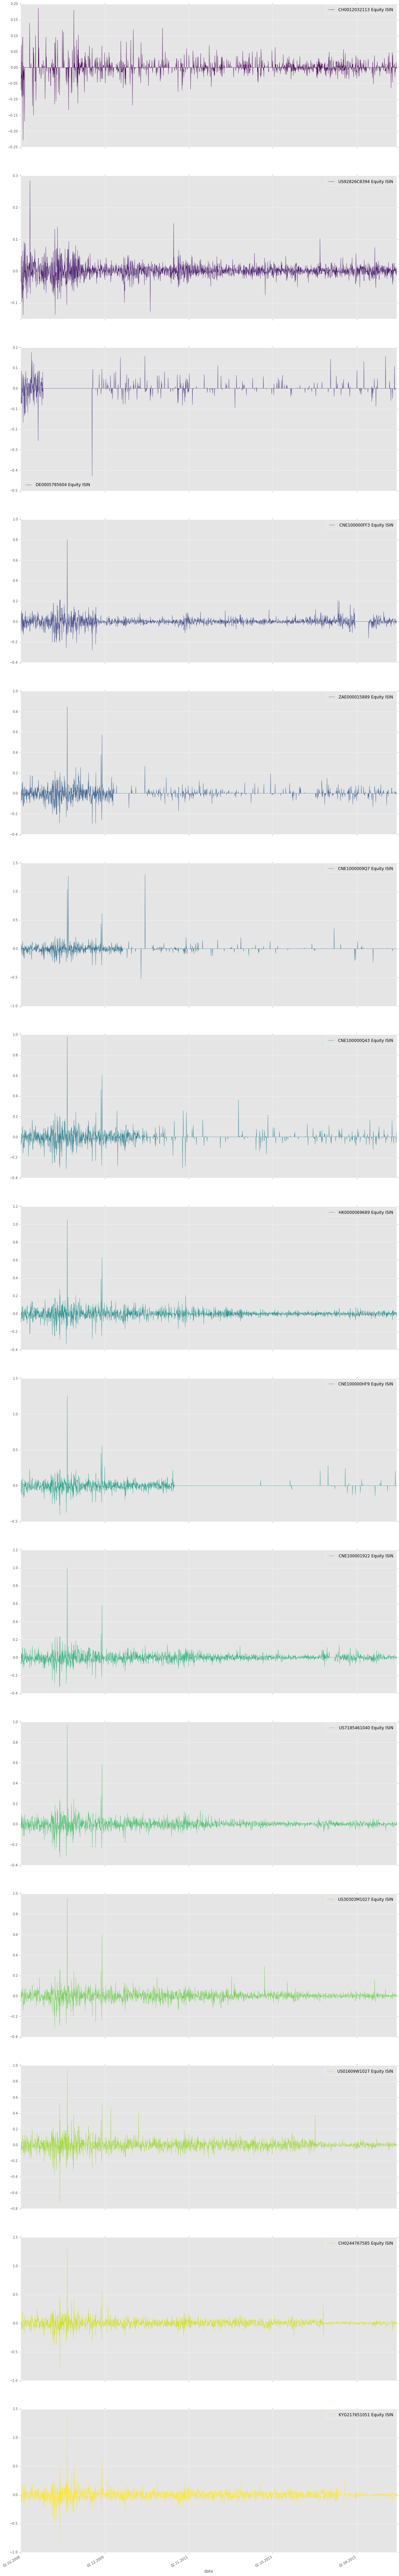

In [3]:
X.loc[:,d.index].plot(subplots=True, figsize=(20,150), cmap='viridis', linewidth=.7)
ax, cax = plot_matrix(mat = X.loc[:,d.index].corr(), figsize=(10,10), title='Collateral portoflio correlation structure - only backfilled assets')
ax, cax = plot_matrix(mat = X.corr(), figsize=(10,10), title='Collateral portoflio correlation structure - all assets')
plt.savefig("matPlot" 
            + "_ApproachFour_mle"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

### Suggestions 
->> Drop backfilled time-series which are clearly too thinly traded and are suceptible to the BBG "simple" backfill procedure i.e. zero returns

->> Use datetime import

```
import datetime
todays_date = datetime.datetime.now().date()
index = pd.date_range(todays_date-datetime.timedelta(10), periods=10, freq='D')
```

->> Use matrix shrinkage for covariance estimation (SKLEARN)

```
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
```

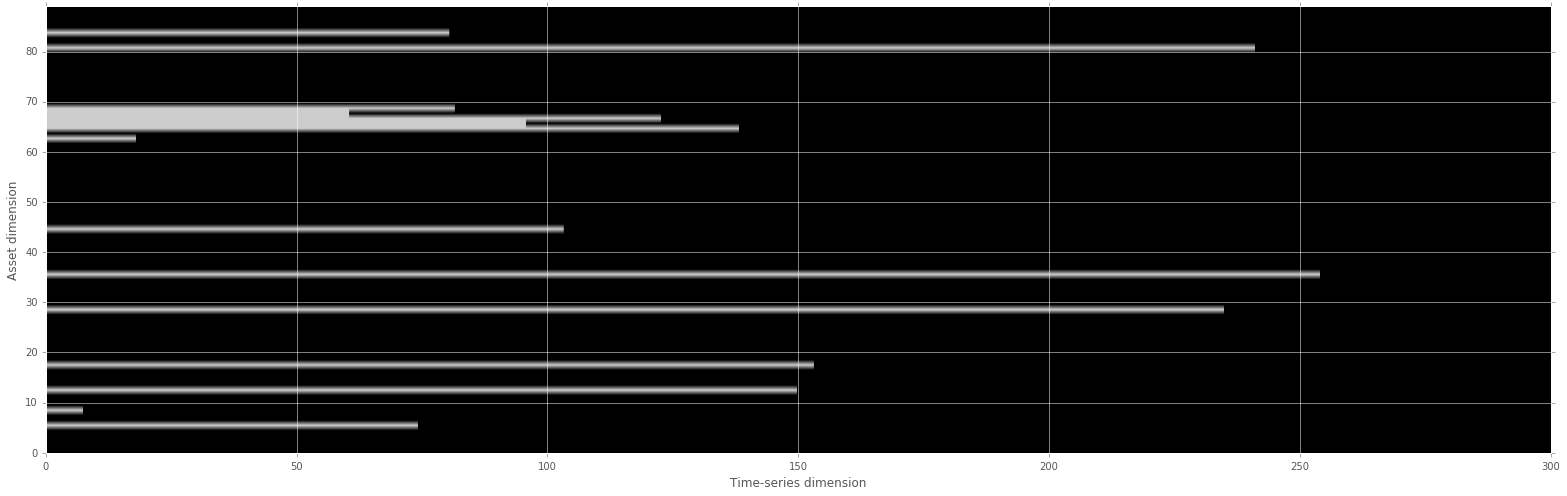

In [71]:
## A plot to visualize missing data pattern
import os
import datetime

#plot_matrix(mat=(dataDict['data'] == "#VALUE"), figsize=(10,3), title='example', cmap=plt.cm.spectral)
#plt.matshow((dataDict['data'] == "#VALUE").transpose())

fig, ax = plt.subplots(figsize=(32,8), dpi=1000)
ax.imshow((dataDict['data'] == "#VALUE").transpose(), extent=[0,300,0,dataDict['data'].shape[1]], cmap='spectral')
ax.set_ylabel('Asset dimension')
ax.set_xlabel('Time-series dimension')
#plt.show()

plt.savefig("matrixPlot" 
            + "_missData"
            + datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d')
            + ".eps", format='eps', dpi=1000, bbox_inches='tight')

# Pre-conclusion code round up
#### ->> Propose that we remove "stale" time-series that are clearly appearing with zero variability over a sufficiently long period of time i.e. 3months of static returns. 

#### ->> Starting first with the series which we have filled-in. For example ISIN: DE00578... ; CNE100...9Q7 ; etc. 

In [4]:
## Removal of "stale" time-series componenets

# Python 3 style division operator w/o the need to convert to float
from __future__ import division

# From the previous indicator df, extract the stale componenets
bucket = {}
for item in d.index:
    bucket.update({item:float(int(sum((X.loc[:,:] == 0)[item])) / X.__len__())})

f=pd.DataFrame(bucket.items(), 
               columns=['ISIN', 'numeric_percent_zero'])
f.index = f.ISIN
f=f.drop('ISIN',1)

# Append information to old indicator df, d, and create new indicator df, e!
e=d
e['numeric_percent_zero'] = f

# Clean up
del f,d

In [14]:
# From the previous indicator df, extract the stale componenets
bucket = {}
meanVec = {}
for item in X.columns:
    bucket.update({item:float(int(sum((X.loc[:,:] == 0)[item])) / X.__len__()):})
    meanVec.update(item:)

print pd.DataFrame(bucket.items())

                           0         1
0   US0846701086 Equity ISIN  0.037963
1   CNE100000Q43 Equity ISIN  0.598035
2   HK2388011192 Equity ISIN  0.548013
3   GB0002374006 Equity ISIN  0.372041
4   US16939P1066 Equity ISIN  0.040197
5   FR0000125486 Equity ISIN  0.832961
6   KYG217651051 Equity ISIN  0.062528
7   CH0011037469 Equity ISIN  0.459580
8   US3696041033 Equity ISIN  0.049576
9   HK0941009539 Equity ISIN  0.477445
10  FR0000131104 Equity ISIN  0.517195
11  GB0009252882 Equity ISIN  0.315319
12  CNE1000001Q4 Equity ISIN  0.918714
13  US0640581007 Equity ISIN  0.042430
14  GB00B03MLX29 Equity ISIN  0.284055
15  CNE1000003W8 Equity ISIN  0.717285
16  CH0012032113 Equity ISIN  0.604288
17  US01609W1027 Equity ISIN  0.009826
18  CNE1000009Q7 Equity ISIN  0.673515
19  CH0012221716 Equity ISIN  0.581510
20  MXP001691213 Equity ISIN  0.680661
21  FR0000120321 Equity ISIN  0.694506
22  CNE1000003G1 Equity ISIN  0.275569
23  JP3902900004 Equity ISIN  0.743636
24  CH0244767585 Equity I

In [17]:
X.mean(axis=0)

AU000000RIO1 Equity ISIN    0.000385
BE0003793107 Equity ISIN    0.000617
CH0011037469 Equity ISIN    0.000471
CH0011075394 Equity ISIN    0.000149
CH0012032048 Equity ISIN    0.000328
CH0012221716 Equity ISIN    0.000139
CH0038863350 Equity ISIN    0.000353
CNE1000001Q4 Equity ISIN    0.000324
CNE1000001Z5 Equity ISIN    0.000498
CNE100000205 Equity ISIN    0.000179
CNE1000002H1 Equity ISIN    0.000312
CNE1000002L3 Equity ISIN    0.000029
CNE1000002M1 Equity ISIN    0.001346
CNE1000002R0 Equity ISIN    0.000042
CNE1000002V2 Equity ISIN    0.000141
CNE1000003G1 Equity ISIN    0.000400
CNE1000003W8 Equity ISIN    0.000353
CNE1000003X6 Equity ISIN    0.000399
DE0005552004 Equity ISIN    0.000230
DE0006599905 Equity ISIN    0.000421
DE0007100000 Equity ISIN    0.000182
DE0007164600 Equity ISIN    0.000453
DE0007236101 Equity ISIN    0.000181
DE000A1EWWW0 Equity ISIN    0.000573
FR0000120321 Equity ISIN    0.000268
FR0000120578 Equity ISIN    0.001081
FR0000120628 Equity ISIN    0.000152
F

In [146]:
# Delete stale time-series, here we try with those that are 15% or more zero valued 
stale = e.loc[e.numeric_percent_zero >= .15].index
noStaleX = X.drop(stale, axis=1)

# Export both to .csv
noStaleX.to_csv(path_or_buf='/Users/Dim/Desktop/school_folder/masters_thesis/gitCodeRepo/data/noStaleX_returnsData_20160825.csv',
                sep=';')
X.to_csv(path_or_buf='/Users/Dim/Desktop/school_folder/masters_thesis/gitCodeRepo/data/X_returnsData_20160825.csv',
                sep=';')

# Conclusions
#### ->> Using the MLE approach yields the best results in OOS tests. The approach is well documented and employed in practice, hence received much more validation.

#### ->> Apply the MLE approach, independently i.e. by using the full information data set, X_T, instead of recursively i.e. filling in the longest series then appending it to X_T, repeating thereafter.

#### ->> Proceed with estimation of covariance step.

#### ->> cvxpy optimizer 

#### –>> Rolling matrix correlation estimation. Creating a covariance matrix, over time, that produces a smooth heatmap effect. Can gauge which areas are 'warm' or 'cool' over time. Python??